### Importing Necessary libraries

In [23]:
import re
import time
import nltk
import string
import sklearn
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

#### Fetching 20 newsgroup data 

In [2]:
from sklearn.datasets import fetch_20newsgroups

train_data = fetch_20newsgroups(subset='train',shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test',shuffle=True, random_state=42)

In [3]:
print('Trainging Data size : ' ,len(train_data.data))
print('Testing Data size : ' ,len(test_data.data))

Trainging Data size :  11314
Testing Data size :  7532


## Training Data

In [4]:
df_train = pd.DataFrame({'data': train_data.data, 'target':train_data.target})
df_train.head()

,data,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


## Testing Data

In [5]:
df_test = pd.DataFrame({'data': test_data.data, 'target':test_data.target})
df_test.head()

,data,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


## Pre-Processing Text

In [6]:
def preprocess_text(string):
    string = re.sub(r"\w*\d\w*", ' ', string)
    string = re.sub('[^\w\s]', ' ', string)
    string = re.sub('[\n]', ' ', string)
    string = re.sub('\s+', ' ', string)

    return string.lower()

### Cleaning training data

In [7]:
begin = time.time()

df_train['data'] = df_train['data'].apply(lambda x: preprocess_text(x))

time.sleep(1)
end = time.time()
print('Time Taken :', end-begin)

Time Taken : 6.554536581039429


### Cleaning test data

In [9]:
begin = time.time()

df_test['data'] = df_test['data'].apply(lambda x: preprocess_text(x))

time.sleep(1)
end = time.time()
print('Time Taken :', end-begin)

Time Taken : 3.8633434772491455


## Feature Extraction / Creating Vocabulary from all the given text data

In [10]:
def create_vocab(text_data):
    vocabulary = {}
    
    # getting stopwords from nltk library
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    
    #Adding word to a vocab if it's not stop word , punctuaution and has length greater than 2
    for file in df_train.data:
        for word in file.split():
            if word not in stop_words and word not in string.punctuation and len(word)!=1 and len(word)!=2:
                if word not in vocabulary.keys():
                    vocabulary[word] = 1
                else:
                    vocabulary[word] += 1

    return vocabulary

In [11]:
vocabulary = create_vocab(df_train.data)
len(vocabulary)

84052

In [12]:
df_v = pd.DataFrame({'keys':vocabulary.keys(), 'values':vocabulary.values()})
df_v.head()

,keys,values
0,lerxst,4
1,wam,81
2,umd,295
3,edu,21321
4,thing,1532


In [13]:
df_v[(df_v['values'] > 10000)].count()

keys      5
values    5
dtype: int64

In [14]:
df_v[(df_v['values'] > 10000)]

,keys,values
3,edu,21321
5,subject,12264
10,organization,11233
15,lines,11835
244,com,12133


There are only 5 values which ocuurs more than 10,000 times. And put of those some looks important like organiztion, lines. So,
I'm removing only values which occurs more than 20,000 times and edu

In [15]:
df_v = df_v[(df_v['values'] < 20000)]
df_v.head()

,keys,values
0,lerxst,4
1,wam,81
2,umd,295
4,thing,1532
5,subject,12264


In [16]:
df_v = df_v.sort_values(by=['values'], ascending=False).reset_index(drop=True)
df_v.head()

,keys,values
0,subject,12264
1,com,12133
2,lines,11835
3,organization,11233
4,one,9008


#### Selecting only top 10000 words as features

In [17]:
df_v = df_v[:10000]
df_v.shape

(10000, 2)

## Frequency of distribution of words

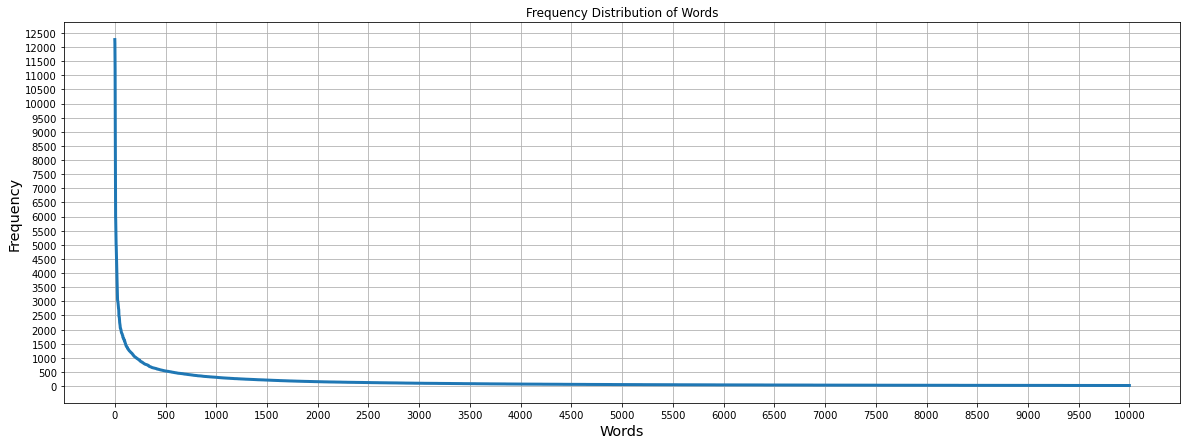

In [18]:
# Plot Figure size
plt.figure(figsize=(20,7))

# Actual plot
plt.plot(df_v['values'], linewidth=3)

# This will add X-axis values range
plt.xticks(range(0, 10500, 500))

# This will add Y-axis values range
plt.yticks(range(0, 13000, 500))


# This will add label to the X-axis
plt.xlabel('Words', size='x-large')

# This will add label to the Y-axis
plt.ylabel('Frequency', size='x-large')

# This will add title to the plot
plt.title('Frequency Distribution of Words')

plt.grid()
plt.show()

#### Inference From the Graph :

    1. Most of the words occur very less frequently
    2. Less than 250 words occurs more than 1000 times 

## Storing Vocabulary in features variable

In [19]:
features = np.array(df_v['keys'])

## Creating a feature vector with extracted features and counting occurence of each word in a document which exists in dictionary

In [34]:
# This function turn the text content into numerical feature vectors which can be passed into ML model.

def convert_text(x_data, features):
    # creating a dummy np array of zeroes with col size same as feature and row size same as actual data point
    final_list = np.zeros((len(x_data), len(features)))
    
    for i in range(len(x_data)):
        #looping over each and every row in the x_data
        curr_file = x_data[i]
        d = dict()
        
        # Addding frequency of every word in a document
        for word in curr_file:
            if word in d.keys():
                d[word] += 1
            else:
                d[word] = 1
        
        # the frequency of each feature in that current document.
        for j in range(len(features)):
            if features[j] in d.keys():
                final_list[i][j] = d[features[j]]
            else:
                #if the current feature is not in the dictionary, it will remain 0 in the modified_data 2D matrix
                continue

    return final_list 

#### Creating training text vector 

In [32]:
# Tokenizing the text row / splitting the whole string into separate words

df_train['data'] = df_train['data'].apply(lambda x: word_tokenize(x))

In [53]:
text_train_vector = convert_text(df_train['data'], features)
text_train_vector.shape

(11314, 10000)

#### Creating test text vector 

In [56]:
# Tokenizing the text row / splitting the whole string into separate words

df_test['data'] = df_test['data'].apply(lambda x: word_tokenize(x))

In [57]:
text_test_vector = convert_text(df_test['data'], features)
text_test_vector.shape

(7532, 10000)

# Implementation Through Inbuilt NB Classifier

##### Initializing the model multinomial NB

In [58]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(text_train_vector, df_train['target'].values)

MultinomialNB()

##### Predicting

In [64]:
predictions_sklearn = clf.predict(text_test_vector)

In [137]:
# Various metrics for understanding how well our model has performed.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report")
print(classification_report(df_test['target'].values, predictions_sklearn, target_names=test_data.target_names))
print()
print("Accuracy Score")
print(accuracy_score(df_test['target'].values, predictions_sklearn) * 100, "%", sep="")

Classification Report
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.77      0.76       319
           comp.graphics       0.60      0.77      0.67       389
 comp.os.ms-windows.misc       0.83      0.51      0.63       394
comp.sys.ibm.pc.hardware       0.60      0.72      0.66       392
   comp.sys.mac.hardware       0.70      0.83      0.76       385
          comp.windows.x       0.88      0.72      0.79       395
            misc.forsale       0.76      0.85      0.80       390
               rec.autos       0.84      0.88      0.86       396
         rec.motorcycles       0.88      0.93      0.91       398
      rec.sport.baseball       0.92      0.91      0.92       397
        rec.sport.hockey       0.95      0.96      0.96       399
               sci.crypt       0.92      0.89      0.90       396
         sci.electronics       0.76      0.69      0.73       393
                 sci.med       0.89      0.79      0.

# My Implementation of NB

In [115]:
# Function that will fit training data
def fit(X_train, Y_train):
    # resultant dictionary
    result = {}
    class_values = set(Y_train)
    
    # looping over each class 
    for current_class in class_values:
        # Each class will have a dictionary
        result[current_class] = {}
        
        num_features = X_train.shape[1]
        
        # Total count store the number of words in a class
        result[current_class]["total_count"] = 0
        X_curr_train = X_train[Y_train == current_class]
        
        for j in range(num_features):
            result[current_class][features[j]] = X_curr_train[:, j].sum()
            
            result[current_class]["total_count"] += result[current_class][features[j]]
                
    return result

# Function to find probability of current class
def probability(dictionary, x, current_class):
    output = 0
    
    for j in range(len(x)):
        if x[j] != 0:
            count_current_class_with_word_j = dictionary[current_class][features[j]] + 1
            count_current_class = dictionary[current_class]["total_count"] + len(x)

            current_word_probablity = np.log(count_current_class_with_word_j) - np.log(count_current_class)
            output += current_word_probablity
    return output

# This function predicts what class a single point belongs to
def predictSinglePoint(dictionary, x):
    classes = dictionary.keys()
    best_p = -1000
    best_class = -1
    first_run = True
    for current_class in classes:
        p_current_class = probability(dictionary, x, current_class)
        if (first_run or p_current_class > best_p):             # Obtaining the class with higher probability
            best_p = p_current_class
            best_class = current_class
        first_run = False
    return best_class

def predict(dictionary, X_test):
    y_pred = []
    for x in X_test:
        x_class = predictSinglePoint(dictionary, x)
        y_pred.append(x_class)
    return y_pred

### Fitting training data 

In [116]:
dictionary = fit(text_train_vector, df_train['target'].values)

### Predicting test data

In [135]:
Y_pred = predict(dictionary, text_test_vector)

In [138]:
# Various metrics for understanding how well our model has performed.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report")
print(classification_report(df_test['target'].values, Y_pred, target_names=test_data.target_names))

print()
print("Accuracy Score")
print(accuracy_score(df_test['target'].values, Y_pred) * 100, "%", sep="")

Classification Report
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.76      0.74       319
           comp.graphics       0.56      0.78      0.66       389
 comp.os.ms-windows.misc       0.85      0.37      0.51       394
comp.sys.ibm.pc.hardware       0.59      0.69      0.63       392
   comp.sys.mac.hardware       0.66      0.82      0.74       385
          comp.windows.x       0.87      0.70      0.78       395
            misc.forsale       0.77      0.85      0.81       390
               rec.autos       0.83      0.89      0.86       396
         rec.motorcycles       0.87      0.92      0.89       398
      rec.sport.baseball       0.93      0.92      0.92       397
        rec.sport.hockey       0.97      0.94      0.96       399
               sci.crypt       0.90      0.87      0.89       396
         sci.electronics       0.74      0.70      0.72       393
                 sci.med       0.89      0.80      0.

## Diff. in Accuracy (Sklearn Model - My implemented ) : 1.17%

## Plotting a graph of counts of target values predicted by Sklearn model, my implementation and actual values

In [200]:
from collections import Counter

my_model_predictions = Counter(Y_pred)
skealrn_predicitons = Counter(predictions_sklearn)
actual_values = Counter(df_test['target'].values)

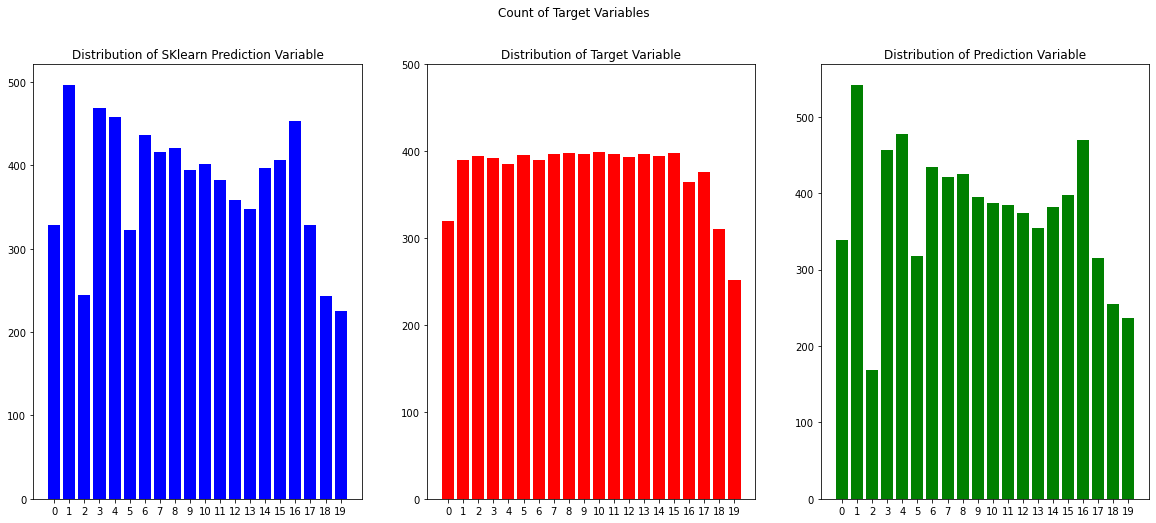

In [206]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
fig.suptitle('Count of Target Variables')

## PLOT FOR SKLEARN PREDICTIONS
ax1.bar(skealrn_predicitons.keys(), skealrn_predicitons.values(), color='b', label='Sklearn Predicted Values')
ax1.set_title('Distribution of SKlearn Prediction Variable')
ax1.set_yticks(range(0,600,100))
ax1.set_xticks(range(0,20))


## PLOT FOR ACTUAL TARGET
ax2.bar(actual_values.keys(), actual_values.values(), color='r', label='True Values')
ax2.set_title('Distribution of Target Variable')
ax2.set_yticks(range(0,600,100))
ax2.set_xticks(range(0,20))


## PLOT FOR MY MODEL IMPLEMENTATION PREDICTIONS
ax3.bar(my_model_predictions.keys(), my_model_predictions.values(), color='g', label='Predicted Values')
ax3.set_title('Distribution of Prediction Variable')
ax3.set_yticks(range(0,600,100))
ax3.set_xticks(range(0,20))

#### Left Side : Inbuilt sklearn model prediction distribution
#### Center :  True values distribution
#### Right Side : My implemented model prediction distribution

##### This Plot shows us the count of each target or output classes by my implemented model and inbuilt sklearn models and thorugh the plot we can see that they're very similiar.